In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "results/dms/merged"

In [19]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,label,DMS,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,11022277,G,A,0.030803,DMS_TADBP_HUMAN_Bolognesi_2019,-2.673625,-6.393,-1.0,-0.581,-10.109375
1,1,11022277,G,C,-0.010471,DMS_TADBP_HUMAN_Bolognesi_2019,-3.286737,-6.393,-1.0,-0.581,-11.539062
2,1,11022277,G,T,0.007680,DMS_TADBP_HUMAN_Bolognesi_2019,-4.006828,-6.393,-1.0,-0.581,-11.328125
3,1,11022278,G,A,0.044342,DMS_TADBP_HUMAN_Bolognesi_2019,-2.628964,-7.618,-1.0,-0.581,-11.328125
4,1,11022278,G,C,0.001282,DMS_TADBP_HUMAN_Bolognesi_2019,-2.423196,-7.618,-1.0,-0.581,-9.906250
...,...,...,...,...,...,...,...,...,...,...,...
41306,22,21867436,G,C,-8.598136,DMS_MK01_HUMAN_Brenan_2016,-3.250944,-5.193,-1.0,-7.713,-10.539062
41307,22,21867436,G,T,-5.301858,DMS_MK01_HUMAN_Brenan_2016,-3.433464,-5.193,-1.0,-7.713,-9.132812
41308,22,21867437,C,A,-8.316191,DMS_MK01_HUMAN_Brenan_2016,-2.446545,-2.833,-1.0,-7.806,-9.390625
41309,22,21867437,C,G,-8.520877,DMS_MK01_HUMAN_Brenan_2016,-3.304997,-2.833,-1.0,-7.806,-10.109375


In [20]:
V.dropna(subset=models, inplace=True)
V.shape

(41311, 11)

In [28]:
rows = []
for DMS in V.DMS.unique():
    V_c = V[V.DMS==DMS]
    for m in models:
        rows.append([DMS, m, spearmanr(V_c.label, V_c[m])[0]])
results = pd.DataFrame(rows, columns=["DMS", "Model", "Spearman"])
results

,DMS,Model,Spearman
0,DMS_TADBP_HUMAN_Bolognesi_2019,CADD,0.046299
1,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-100-vertebrates,-0.068083
2,DMS_TADBP_HUMAN_Bolognesi_2019,phastCons-100-vertebrates,0.016584
3,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-241-mammals,0.077465
4,DMS_TADBP_HUMAN_Bolognesi_2019,GPN-MSA,-0.071710
...,...,...,...
150,DMS_MK01_HUMAN_Brenan_2016,CADD,0.096117
151,DMS_MK01_HUMAN_Brenan_2016,phyloP-100-vertebrates,-0.017284
152,DMS_MK01_HUMAN_Brenan_2016,phastCons-100-vertebrates,-0.027703
153,DMS_MK01_HUMAN_Brenan_2016,phyloP-241-mammals,0.014495


In [29]:
results.groupby("Model")["Spearman"].mean().sort_values(ascending=False)

Model
CADD                         0.336891
GPN-MSA                      0.321054
phyloP-100-vertebrates       0.229632
phastCons-100-vertebrates    0.155790
phyloP-241-mammals           0.140478
Name: Spearman, dtype: float64

In [31]:
results.groupby("Model")["Spearman"].median().sort_values(ascending=False)

Model
GPN-MSA                      0.349509
CADD                         0.320596
phyloP-100-vertebrates       0.273353
phyloP-241-mammals           0.151679
phastCons-100-vertebrates    0.141818
Name: Spearman, dtype: float64

In [39]:
results.groupby("DMS")["Spearman"].median().sort_values(ascending=False)

DMS
DMS_NUD15_HUMAN_Suiter_2020                     0.475466
DMS_CP2C9_HUMAN_Amorosi_activity_2021           0.457248
DMS_CP2C9_HUMAN_Amorosi_abundance_2021          0.439921
DMS_P53_HUMAN_Giacomelli_WT_Nutlin_2018         0.418756
DMS_TPMT_HUMAN_Matreyek_2018                    0.391892
DMS_VKOR1_HUMAN_Chiasson_abundance_2020         0.335273
DMS_P53_HUMAN_Kotler_2018                       0.333885
DMS_P53_HUMAN_Giacomelli_NULL_Etoposide_2018    0.331321
DMS_ADRB2_HUMAN_Jones_2020                      0.330929
DMS_BRCA1_HUMAN_Findlay_2018                    0.313417
DMS_SC6A4_HUMAN_Young_2021                      0.305009
DMS_YAP1_HUMAN_Araya_2012                       0.291687
DMS_TPOR_HUMAN_Bridgford_S505N_2020             0.285447
DMS_P53_HUMAN_Giacomelli_NULL_Nutlin_2018       0.284646
DMS_GRB2_HUMAN_Faure_2021                       0.283203
DMS_VKOR1_HUMAN_Chiasson_activity_2020          0.273353
DMS_DLG4_HUMAN_Faure_2021                       0.269685
DMS_KCNH2_HUMAN_Kozek_2020 

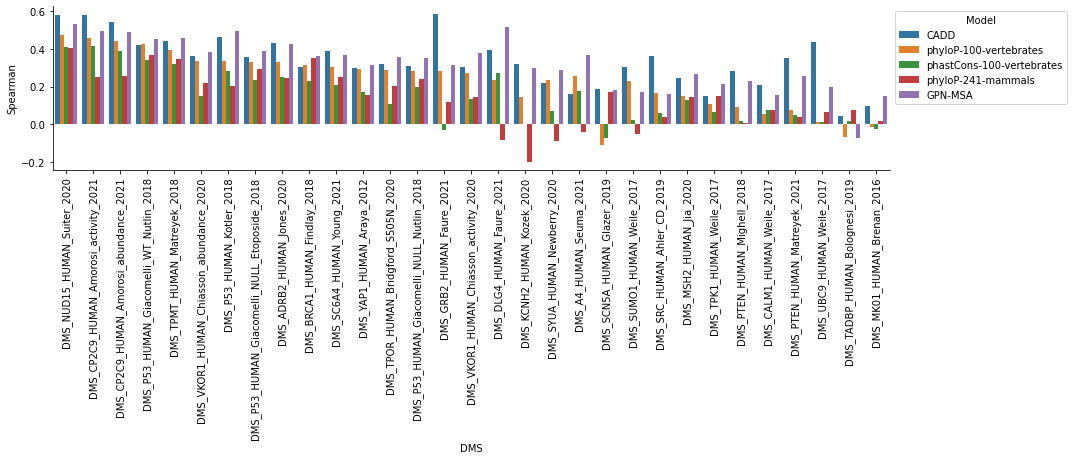

In [40]:
plt.figure(figsize=(15,3))
g = sns.barplot(
    data=results, x="DMS", hue="Model", y="Spearman",
    order=results.groupby("DMS")["Spearman"].median().sort_values(ascending=False).index.values
);
g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='center')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine();

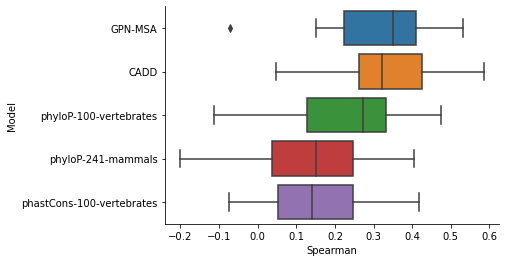

In [42]:
#plt.figure(figsize=(15,3))
g = sns.boxplot(
    data=results, y="Model", x="Spearman",
    order=results.groupby("Model")["Spearman"].median().sort_values(ascending=False).index.values
);
#g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='center')
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine();